## Imports

In [1]:
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import RFECV
from lightgbm import LGBMRegressor, LGBMClassifier
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, mean_squared_error

/Users/vivan/miniconda3/envs/DSO530/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Change file location to Data

In [3]:
head, tail = os.path.split(os.getcwd())
os.chdir(os.path.join(head,'01_Data'))

In [4]:
os.listdir()

['insurance_train.csv',
 'cleaned_test.csv',
 'cleaned_data.parquet',
 'cleaned_data.csv',
 'cleaned_test.parquet',
 'insurance_test.csv',
 'cleaned_test.pkl',
 'cleaned_data.pkl']

## Reading data

In [5]:
data = pd.read_parquet('cleaned_data.parquet')
data.head()

ID Start_Date_Contract Date_Last_Renewal Date_Next_Renewal  \
0  34429          2017-06-01        2017-06-01        2018-06-01   
1   5552          2016-09-19        2018-09-19        2019-09-19   
2  47700          2003-01-08        2018-01-08        2019-01-08   
3  25425          2015-10-01        2018-10-01        2019-10-01   
4   4727          2017-01-26        2018-01-26        2019-01-26   

  Date_Of_Birth Date_Of_DL_Issuance  Issurance_Broker_Agent_Channel  \
0    1996-08-29          2016-05-31                               0   
1    1992-04-30          2010-08-03                               0   
2    1972-03-23          1998-02-01                               1   
3    1946-03-05          1964-08-07                               0   
4    1973-04-25          1998-07-24                               0   

   Years_Associates  Total_Policies_Entity  Max_Policy_Simultaneous_Force  \
0                 1                      1                              1   
1                 3                      1                              1   
2                20                      2                              2   
3                 8                      2                              3   
4                 9                      1                              1   

   ...  Non_Continuation_Insurance_Flag  New_License  Car_Age_Cat  \
0  ...                                1            0          Old   
1  ...                                0            0     Standard   
2  ...                                0            0          Old   
3  ...                                0            0     Standard   
4  ...                                0            0          Old   

   Ratio_Premium_Car_Value  Power_Wt_Ratio  Customer_Loyalty  New_Bhp_Risk  \
0                 0.044787        0.072115              1.00             0   
1                 0.019446        0.085837              1.70             0   
2                 0.015644        0.076923              8.15             0   
3                 0.010544        0.070565              4.15             0   
4                 0.020250        0.047004              3.80             0   

   Years_Driving_At_Start_Date  Young_Driver  Young_Bhp_Risk  
0                            1             1               0  
1                            6             0               0  
2                            5             0               0  
3                           51             0               0  
4                           19             0               0  

[5 rows x 46 columns]

In [6]:
data.columns

Index(['ID', 'Start_Date_Contract', 'Date_Last_Renewal', 'Date_Next_Renewal',
       'Date_Of_Birth', 'Date_Of_DL_Issuance',
       'Issurance_Broker_Agent_Channel', 'Years_Associates',
       'Total_Policies_Entity', 'Max_Policy_Simultaneous_Force',
       'Max_Product_Simultaneous_Held', 'Policies_Terminated_Non_Payment',
       'Half_Yearly_Payment_Method', 'Premium_Amt_Current_Yr',
       'Total_Cost_Claims_Current_Yr', 'Total_Number_Claims_Current_Yr',
       'Total_Number_Claims_Entire_Duration',
       'Ratio_Claims_Total_Duration_Force',
       'Motorbikes_Vans_Cars_Agricultural', 'Rural_Urban_Flag',
       'Multiple_Drivers_Regular_Flag', 'Yr_Vehicle_Registration',
       'Vehicle_Power_HP', 'Cylinder_Capacity', 'Market_Value_EOY19',
       'Vehicle_Doors', 'Energy_Source', 'Vehicle_Wt_Kg', 'Loss_Cost',
       'Historically_Adjusted_Loss_Cost', 'Claim_Status', 'Age',
       'Years_Driving', 'Car_Age', 'Time_Since_Last_Renewal',
       'Non_Payment_Termination', 'Non_Continuati

In [7]:
X = data.copy()

In [8]:
X = X.drop(columns=['ID', 'Total_Cost_Claims_Current_Yr', 'Total_Number_Claims_Current_Yr',
                    'Total_Number_Claims_Entire_Duration', 'Ratio_Claims_Total_Duration_Force',
                    'Loss_Cost', 'Historically_Adjusted_Loss_Cost', 'Claim_Status'])
X.columns

Index(['Start_Date_Contract', 'Date_Last_Renewal', 'Date_Next_Renewal',
       'Date_Of_Birth', 'Date_Of_DL_Issuance',
       'Issurance_Broker_Agent_Channel', 'Years_Associates',
       'Total_Policies_Entity', 'Max_Policy_Simultaneous_Force',
       'Max_Product_Simultaneous_Held', 'Policies_Terminated_Non_Payment',
       'Half_Yearly_Payment_Method', 'Premium_Amt_Current_Yr',
       'Motorbikes_Vans_Cars_Agricultural', 'Rural_Urban_Flag',
       'Multiple_Drivers_Regular_Flag', 'Yr_Vehicle_Registration',
       'Vehicle_Power_HP', 'Cylinder_Capacity', 'Market_Value_EOY19',
       'Vehicle_Doors', 'Energy_Source', 'Vehicle_Wt_Kg', 'Age',
       'Years_Driving', 'Car_Age', 'Time_Since_Last_Renewal',
       'Non_Payment_Termination', 'Non_Continuation_Insurance_Flag',
       'New_License', 'Car_Age_Cat', 'Ratio_Premium_Car_Value',
       'Power_Wt_Ratio', 'Customer_Loyalty', 'New_Bhp_Risk',
       'Years_Driving_At_Start_Date', 'Young_Driver', 'Young_Bhp_Risk'],
      dtype='object')

In [9]:
Y_reg = data[['Loss_Cost','Historically_Adjusted_Loss_Cost']]
Y_class = data[['Claim_Status']]

## Fixing the X data

In [10]:
X.isna().sum()

Start_Date_Contract                    0
Date_Last_Renewal                      0
Date_Next_Renewal                      0
Date_Of_Birth                          0
Date_Of_DL_Issuance                    0
Issurance_Broker_Agent_Channel         0
Years_Associates                       0
Total_Policies_Entity                  0
Max_Policy_Simultaneous_Force          0
Max_Product_Simultaneous_Held          0
Policies_Terminated_Non_Payment        0
Half_Yearly_Payment_Method             0
Premium_Amt_Current_Yr                 0
Motorbikes_Vans_Cars_Agricultural      0
Rural_Urban_Flag                       0
Multiple_Drivers_Regular_Flag          0
Yr_Vehicle_Registration                0
Vehicle_Power_HP                       0
Cylinder_Capacity                      0
Market_Value_EOY19                     0
Vehicle_Doors                          0
Energy_Source                        593
Vehicle_Wt_Kg                          0
Age                                    0
Years_Driving   

In [11]:
data.isna().sum()[data.isna().sum() > 0]

Energy_Source                        593
Loss_Cost                          33300
Historically_Adjusted_Loss_Cost    33300
dtype: int64

In [12]:
data.loc[data['Energy_Source'].isna(),'Claim_Status'].value_counts()

Claim_Status
0    564
1     29
Name: count, dtype: int64

We can fill the X['Energy_Source'] with other

In [13]:
X['Energy_Source'] = X['Energy_Source'].fillna('Other')
X['Energy_Source'].value_counts(dropna = False)

Energy_Source
D        23074
P        13784
Other      593
Name: count, dtype: int64

Create categorical variables

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37451 entries, 0 to 37450
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Start_Date_Contract                37451 non-null  datetime64[ns]
 1   Date_Last_Renewal                  37451 non-null  datetime64[ns]
 2   Date_Next_Renewal                  37451 non-null  datetime64[ns]
 3   Date_Of_Birth                      37451 non-null  datetime64[ns]
 4   Date_Of_DL_Issuance                37451 non-null  datetime64[ns]
 5   Issurance_Broker_Agent_Channel     37451 non-null  int64         
 6   Years_Associates                   37451 non-null  int64         
 7   Total_Policies_Entity              37451 non-null  int64         
 8   Max_Policy_Simultaneous_Force      37451 non-null  int64         
 9   Max_Product_Simultaneous_Held      37451 non-null  int64         
 10  Policies_Terminated_Non_Payment   

In [15]:
X = pd.get_dummies(X, columns=['Car_Age_Cat', 'Energy_Source'], dtype=int, drop_first=False)
X.head()

Start_Date_Contract Date_Last_Renewal Date_Next_Renewal Date_Of_Birth  \
0          2017-06-01        2017-06-01        2018-06-01    1996-08-29   
1          2016-09-19        2018-09-19        2019-09-19    1992-04-30   
2          2003-01-08        2018-01-08        2019-01-08    1972-03-23   
3          2015-10-01        2018-10-01        2019-10-01    1946-03-05   
4          2017-01-26        2018-01-26        2019-01-26    1973-04-25   

  Date_Of_DL_Issuance  Issurance_Broker_Agent_Channel  Years_Associates  \
0          2016-05-31                               0                 1   
1          2010-08-03                               0                 3   
2          1998-02-01                               1                20   
3          1964-08-07                               0                 8   
4          1998-07-24                               0                 9   

   Total_Policies_Entity  Max_Policy_Simultaneous_Force  \
0                      1                              1   
1                      1                              1   
2                      2                              2   
3                      2                              3   
4                      1                              1   

   Max_Product_Simultaneous_Held  ...  Years_Driving_At_Start_Date  \
0                              1  ...                            1   
1                              1  ...                            6   
2                              1  ...                            5   
3                              1  ...                           51   
4                              1  ...                           19   

   Young_Driver  Young_Bhp_Risk  Car_Age_Cat_New  Car_Age_Cat_Recent  \
0             1               0                0                   0   
1             0               0                0                   0   
2             0               0                0                   0   
3             0               0                0                   0   
4             0               0                0                   0   

   Car_Age_Cat_Standard  Car_Age_Cat_Old  Energy_Source_D  \
0                     0                1                0   
1                     1                0                1   
2                     0                1                0   
3                     1                0                1   
4                     0                1                0   

   Energy_Source_Other  Energy_Source_P  
0                    0                1  
1                    0                0  
2                    0                1  
3                    0                0  
4                    0                1  

[5 rows x 43 columns]

In [16]:
X[['Car_Age_Cat_New','Car_Age_Cat_Recent','Car_Age_Cat_Standard','Car_Age_Cat_Old']].sum()

Car_Age_Cat_New          2159
Car_Age_Cat_Recent       3402
Car_Age_Cat_Standard    16978
Car_Age_Cat_Old         14912
dtype: int64

In [17]:
X = X.drop(columns=['Car_Age_Cat_New', 'Energy_Source_Other'])

Now we need to drop time

In [18]:
X = X.drop(columns=['Start_Date_Contract','Date_Last_Renewal','Date_Next_Renewal','Date_Of_Birth','Date_Of_DL_Issuance'])

## Fixing Y

In [19]:
Y_reg = Y_reg.fillna(0)

In [20]:
Y_reg.value_counts()

Loss_Cost   Historically_Adjusted_Loss_Cost
0.000       0.00000                            33300
882.000     882.00000                             40
            1764.00000                            10
            1746.36000                             9
            1755.18000                             8
                                               ...  
96.150      192.30000                              1
96.300      135.78300                              1
96.335      230.24065                              1
96.410      157.14830                              1
118142.590  236285.18000                           1
Name: count, Length: 3906, dtype: int64

## Now we need to split the data appropriately

We need to stratify it while splitting

In [21]:
X_class_train, X_class_test, Y_class_train, Y_class_test = train_test_split(
    X, Y_class,
    test_size=0.2,
    stratify=Y_class,
    random_state=42
)

print(X_class_test.shape)
print(X_class_train.shape)
print(Y_class_test.shape)
print(Y_class_train.shape)

(7491, 36)
(29960, 36)
(7491, 1)
(29960, 1)


In [22]:
display(Y_class_train.value_counts(normalize=True))
display(Y_class_test.value_counts(normalize=True))

Claim_Status
0               0.889152
1               0.110848
Name: proportion, dtype: float64

Claim_Status
0               0.8892
1               0.1108
Name: proportion, dtype: float64

For regressors we need to mention 0 before stratify

In [23]:
# using Loss Cost as HALC might have some 0
zero_flag = (Y_reg['Loss_Cost'] == 0).astype(int)
zero_flag.value_counts(dropna=False)

Loss_Cost
1    33300
0     4151
Name: count, dtype: int64

In [24]:
X_reg_train, X_reg_test, Y_reg_train, Y_reg_test = train_test_split(
    X, Y_reg,
    test_size=0.2,
    stratify=zero_flag,
    random_state=42
)

In [25]:
print(X_reg_test.shape)
print(X_reg_train.shape)
print(Y_reg_test.shape)
print(Y_reg_train.shape)

(7491, 36)
(29960, 36)
(7491, 2)
(29960, 2)


In [26]:
display(len(Y_reg_train[Y_reg_train['Loss_Cost']==0])/len(Y_reg_train))
display(len(Y_reg_test[Y_reg_test['Loss_Cost']==0])/len(Y_reg_test))

0.8891522029372496

0.8892003737818716

## Variable selection

In [27]:
def make_stratify_bins(y, n_bins=10):
    return pd.qcut(y, q=n_bins, duplicates='drop', labels=False)

In [28]:
def select_features_with_rfecv(X, y, objective="regression"):
    from lightgbm import LGBMRegressor, LGBMClassifier
    from sklearn.feature_selection import RFECV

    estimator = LGBMRegressor(random_state=42) if objective == "regression" else LGBMClassifier(random_state=42)
    scoring = "neg_root_mean_squared_error" if objective == "regression" else "roc_auc"

    if objective == "regression":
        y_strat = make_stratify_bins(y, n_bins=5)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    else:
        y_strat = y
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    rfecv = RFECV(estimator=estimator, step=1, cv=cv, scoring=scoring)
    rfecv.fit(X, y_strat)

    plt.figure(figsize=(10, 4))
    plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
    plt.xlabel("Number of Features Selected")
    plt.ylabel("Cross-Validation Score")
    plt.title("RFECV Performance by Number of Features")
    plt.tight_layout()
    plt.show()

    selected_features = X.columns[rfecv.support_].tolist()
    print(f"Selected {len(selected_features)} features out of {X.shape[1]}")
    return X[selected_features]

## Hyper parameter tuning

### Creating a function to use on optuna 

In [29]:


def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def tune_lightgbm(X, y, folds, objective, scorer, use_gpu=False, show_plots=False):
    """
    X : predictors (DataFrame)
    y : target (Series)
    folds : a StratifiedKFold object
    objective : "tweedie" or "binary"
    scorer : "rmse" or "auc"
    use_gpu : Set to True to enable GPU (default False)
    show_plots : If True, displays Optuna visualizations (default False)
    """

    direction = "minimize" if scorer == "rmse" else "maximize"

    if scorer == "rmse":
        y_strat = make_stratify_bins(y)
    else:
        y_strat = y

    def objective_fn(trial):
        params = {
            "objective": objective,
            "learning_rate": trial.suggest_float("lr", 0.01, 0.2, log=True),
            "num_leaves": trial.suggest_int("leaves", 16, 255),
            "feature_fraction": trial.suggest_float("ff", 0.5, 1.0),
            "bagging_fraction": trial.suggest_float("bf", 0.5, 1.0),
            "bagging_freq": 1,
            "max_depth": -1,
            "lambda_l1": trial.suggest_float("l1", 0.0, 5.0),
            "lambda_l2": trial.suggest_float("l2", 0.0, 5.0),
            "random_state": 42,
            "verbosity": -1
        }

        if use_gpu:
            params["device"] = "gpu"
            params["gpu_platform_id"] = 0
            params["gpu_device_id"] = 0

        if objective == "tweedie":
            params["tweedie_variance_power"] = trial.suggest_float("p", 1.1, 1.9)
        if objective == "binary":
            params["is_unbalance"] = True

        scores = []

        for tr_idx, val_idx in folds.split(X, y_strat):
            X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

            model = (
                LGBMRegressor(**params, n_estimators=5000)
                if objective == "tweedie"
                else LGBMClassifier(**params, n_estimators=5000)
            )

            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                eval_metric=scorer
            )

            preds = model.predict(X_val)

            if scorer == "rmse":
                scores.append(rmse(y_val, preds))
            else:
                scores.append(roc_auc_score(y_val, preds))

        return np.mean(scores)

    study = optuna.create_study(direction=direction)
    study.optimize(objective_fn, n_trials=60, timeout=1800, show_progress_bar=True)

    if show_plots:
        try:
            from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

            plot_optimization_history(study)
            plt.title("Optuna Optimization History")
            plt.tight_layout()
            plt.show()

            plot_param_importances(study)
            plt.title("Hyperparameter Importance")
            plt.tight_layout()
            plt.show()
        except ImportError:
            print("Install matplotlib and optuna[visualization] to enable plots.")

    return study.best_params

## Now we need to select variables and tune each model

### Loss Cost

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2367
[LightGBM] [Info] Number of data points in the train set: 23968, number of used features: 34
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped traini

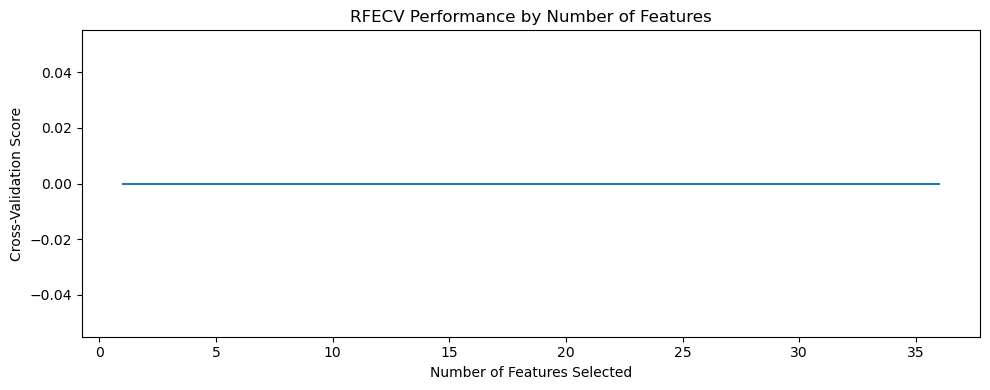

[I 2025-04-19 18:02:45,212] A new study created in memory with name: no-name-df7ed1f7-1e48-40de-a211-9fc99eb53f60


Selected 1 features out of 36


Best trial: 0. Best value: 531.336:   2%|▏         | 1/60 [00:11<11:12, 11.39s/it, 11.39/1800 seconds]

[I 2025-04-19 18:02:56,639] Trial 0 finished with value: 531.335710774558 and parameters: {'lr': 0.17419727866285895, 'leaves': 212, 'ff': 0.6111938619170167, 'bf': 0.9297136035460889, 'l1': 4.808208588938691, 'l2': 3.414644111345466, 'p': 1.66631710638654}. Best is trial 0 with value: 531.335710774558.


Best trial: 1. Best value: 531.329:   3%|▎         | 2/60 [00:20<09:57, 10.30s/it, 20.93/1800 seconds]

[I 2025-04-19 18:03:06,170] Trial 1 finished with value: 531.3294487359243 and parameters: {'lr': 0.026411818269958854, 'leaves': 67, 'ff': 0.5757562552213622, 'bf': 0.7322130450926717, 'l1': 0.5063029764596372, 'l2': 4.051934328178104, 'p': 1.3837402323738126}. Best is trial 1 with value: 531.3294487359243.


Best trial: 2. Best value: 531.327:   5%|▌         | 3/60 [00:31<09:50, 10.36s/it, 31.37/1800 seconds]

[I 2025-04-19 18:03:16,613] Trial 2 finished with value: 531.3274667881911 and parameters: {'lr': 0.022834579640152557, 'leaves': 138, 'ff': 0.7971494170575188, 'bf': 0.7016152719805784, 'l1': 3.592179229425734, 'l2': 0.7402558173781654, 'p': 1.5803533010689825}. Best is trial 2 with value: 531.3274667881911.


Best trial: 2. Best value: 531.327:   7%|▋         | 4/60 [00:42<09:49, 10.53s/it, 42.15/1800 seconds]

[I 2025-04-19 18:03:27,392] Trial 3 finished with value: 531.3297927404308 and parameters: {'lr': 0.06639122432875508, 'leaves': 131, 'ff': 0.8198970285769099, 'bf': 0.6019096966770361, 'l1': 0.7896802445351103, 'l2': 0.20672520947727924, 'p': 1.1042689849228733}. Best is trial 2 with value: 531.3274667881911.


Best trial: 4. Best value: 531.326:   8%|▊         | 5/60 [00:54<10:09, 11.09s/it, 54.23/1800 seconds]

[I 2025-04-19 18:03:39,472] Trial 4 finished with value: 531.3256261573929 and parameters: {'lr': 0.032366487833231324, 'leaves': 168, 'ff': 0.8118971611246176, 'bf': 0.5783256589887782, 'l1': 2.8276680435022468, 'l2': 0.10378211299982176, 'p': 1.575936673136432}. Best is trial 4 with value: 531.3256261573929.


Best trial: 4. Best value: 531.326:  10%|█         | 6/60 [01:05<09:57, 11.06s/it, 65.22/1800 seconds]

[I 2025-04-19 18:03:50,468] Trial 5 finished with value: 531.3272287527647 and parameters: {'lr': 0.012467909235317801, 'leaves': 253, 'ff': 0.5330563737965759, 'bf': 0.6309164973030585, 'l1': 4.632547646159699, 'l2': 0.4069742673060417, 'p': 1.758974403668749}. Best is trial 4 with value: 531.3256261573929.


Best trial: 4. Best value: 531.326:  12%|█▏        | 7/60 [01:16<09:47, 11.09s/it, 76.37/1800 seconds]

[I 2025-04-19 18:04:01,619] Trial 6 finished with value: 531.3274587333951 and parameters: {'lr': 0.16196181749427863, 'leaves': 174, 'ff': 0.642248304824192, 'bf': 0.6364268344112981, 'l1': 0.010507068240279138, 'l2': 3.7044789879894813, 'p': 1.404086756115806}. Best is trial 4 with value: 531.3256261573929.


Best trial: 4. Best value: 531.326:  13%|█▎        | 8/60 [01:26<09:26, 10.90s/it, 86.87/1800 seconds]

[I 2025-04-19 18:04:12,114] Trial 7 finished with value: 531.3297681568966 and parameters: {'lr': 0.16421810166500014, 'leaves': 240, 'ff': 0.7540007911950363, 'bf': 0.7865950608826195, 'l1': 3.0952406115293196, 'l2': 3.1720282679494143, 'p': 1.3381322279040317}. Best is trial 4 with value: 531.3256261573929.


Best trial: 8. Best value: 531.323:  15%|█▌        | 9/60 [01:38<09:25, 11.09s/it, 98.38/1800 seconds]

[I 2025-04-19 18:04:23,627] Trial 8 finished with value: 531.3225861836112 and parameters: {'lr': 0.025065839775190238, 'leaves': 75, 'ff': 0.9352558883744271, 'bf': 0.5187985016006293, 'l1': 0.611135086432314, 'l2': 4.153331059689372, 'p': 1.5658370146082943}. Best is trial 8 with value: 531.3225861836112.


Best trial: 8. Best value: 531.323:  17%|█▋        | 10/60 [01:47<08:48, 10.56s/it, 107.77/1800 seconds]

[I 2025-04-19 18:04:33,011] Trial 9 finished with value: 531.3286584346328 and parameters: {'lr': 0.13307102727731313, 'leaves': 214, 'ff': 0.9483308036280935, 'bf': 0.5863938952723138, 'l1': 1.8461753070394338, 'l2': 0.21394221840736527, 'p': 1.5912322410275963}. Best is trial 8 with value: 531.3225861836112.


Best trial: 8. Best value: 531.323:  18%|█▊        | 11/60 [01:57<08:25, 10.31s/it, 117.49/1800 seconds]

[I 2025-04-19 18:04:42,739] Trial 10 finished with value: 531.3260407455515 and parameters: {'lr': 0.010882375777804423, 'leaves': 18, 'ff': 0.986649256830364, 'bf': 0.8497047500680298, 'l1': 1.5964345066568102, 'l2': 4.8715046698680915, 'p': 1.8953365155494175}. Best is trial 8 with value: 531.3225861836112.


Best trial: 11. Best value: 531.322:  20%|██        | 12/60 [02:08<08:26, 10.54s/it, 128.58/1800 seconds]

[I 2025-04-19 18:04:53,825] Trial 11 finished with value: 531.3223630861171 and parameters: {'lr': 0.0323958382407855, 'leaves': 91, 'ff': 0.8744944072371299, 'bf': 0.5069687778327453, 'l1': 2.4565497179431492, 'l2': 1.8864388505593481, 'p': 1.5038487611379818}. Best is trial 11 with value: 531.3223630861171.


Best trial: 11. Best value: 531.322:  22%|██▏       | 13/60 [02:17<07:57, 10.16s/it, 137.86/1800 seconds]

[I 2025-04-19 18:05:03,103] Trial 12 finished with value: 531.3229182212597 and parameters: {'lr': 0.055739009166088566, 'leaves': 75, 'ff': 0.8977185223854699, 'bf': 0.502184619457718, 'l1': 1.7987591707583779, 'l2': 1.7408531574278854, 'p': 1.242985097486479}. Best is trial 11 with value: 531.3223630861171.


Best trial: 11. Best value: 531.322:  23%|██▎       | 14/60 [02:28<07:48, 10.19s/it, 148.11/1800 seconds]

[I 2025-04-19 18:05:13,359] Trial 13 finished with value: 531.3243672528849 and parameters: {'lr': 0.017554680433887224, 'leaves': 80, 'ff': 0.8902032391790274, 'bf': 0.5037573983495502, 'l1': 3.713148647501597, 'l2': 1.8972838429590795, 'p': 1.4806273752448338}. Best is trial 11 with value: 531.3223630861171.


In [30]:
# a) Pipeline for Loss_Cost (LC)
X_lc_selected = select_features_with_rfecv(X_reg_train, Y_reg_train["Loss_Cost"], objective="regression")
skf_lc = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_lc_params = tune_lightgbm(X_lc_selected, Y_reg_train["Loss_Cost"], skf_lc, "tweedie", "rmse")
X_lc_test_selected = X_reg_test[X_lc_selected.columns]

### HALC

In [ ]:
# b) Pipeline for Historically_Adjusted_Loss_Cost (HALC)
X_halc_selected = select_features_with_rfecv(X_reg_train, Y_reg_train["Historically_Adjusted_Loss_Cost"], objective="regression")
skf_halc = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_halc_params = tune_lightgbm(X_halc_selected, Y_reg_train["Historically_Adjusted_Loss_Cost"], skf_halc, "tweedie", "rmse")
X_halc_test_selected = X_reg_test[X_halc_selected.columns]

[I 2025-04-19 05:05:48,779] A new study created in memory with name: no-name-ceb40e14-fc55-4ab9-b59e-77324f754972
Best trial: 0. Best value: 1161.3:   2%| | 1/60 [00:53<52:50, 53.74s/it, 53.74/1

[I 2025-04-19 05:06:42,519] Trial 0 finished with value: 1161.2982193134587 and parameters: {'lr': 0.06521472911186472, 'leaves': 43, 'ff': 0.5343117980000834, 'bf': 0.9511078509739688, 'l1': 1.8458086631584232, 'l2': 0.045960108316501214, 'p': 1.6583592642591882}. Best is trial 0 with value: 1161.2982193134587.


Best trial: 0. Best value: 1161.3:   3%| | 2/60 [01:34<44:29, 46.02s/it, 94.36/1

[I 2025-04-19 05:07:23,135] Trial 1 finished with value: 1169.7231733843369 and parameters: {'lr': 0.18655824673704682, 'leaves': 25, 'ff': 0.5469591037037946, 'bf': 0.5702052871085127, 'l1': 1.4413061364134099, 'l2': 2.258850830571624, 'p': 1.689733221774366}. Best is trial 0 with value: 1161.2982193134587.


Best trial: 2. Best value: 1156.09:   5%| | 3/60 [02:28<47:07, 49.60s/it, 148.22

[I 2025-04-19 05:08:16,999] Trial 2 finished with value: 1156.0933555383176 and parameters: {'lr': 0.011529065001747767, 'leaves': 46, 'ff': 0.7671386565578402, 'bf': 0.6593634517966287, 'l1': 0.6826736026918478, 'l2': 2.9683011599298146, 'p': 1.3800416656678907}. Best is trial 2 with value: 1156.0933555383176.


Best trial: 2. Best value: 1156.09:   7%| | 4/60 [05:43<1:40:09, 107.31s/it, 343

[I 2025-04-19 05:11:32,766] Trial 3 finished with value: 1160.6975723587514 and parameters: {'lr': 0.1354278150683325, 'leaves': 255, 'ff': 0.521145647763823, 'bf': 0.7029372132520524, 'l1': 1.0255825828714897, 'l2': 2.95064790821573, 'p': 1.103889749612235}. Best is trial 2 with value: 1156.0933555383176.


Best trial: 2. Best value: 1156.09:   8%| | 5/60 [08:28<1:57:24, 128.07s/it, 508

[I 2025-04-19 05:14:17,663] Trial 4 finished with value: 1161.0547081584518 and parameters: {'lr': 0.08723317337746563, 'leaves': 210, 'ff': 0.6742329908082023, 'bf': 0.8768822547549059, 'l1': 1.3779017371803075, 'l2': 4.947426318184477, 'p': 1.240215573087234}. Best is trial 2 with value: 1156.0933555383176.


Best trial: 2. Best value: 1156.09:  10%| | 6/60 [11:06<2:04:16, 138.08s/it, 666

[I 2025-04-19 05:16:55,156] Trial 5 finished with value: 1161.1769998318484 and parameters: {'lr': 0.015170043311859189, 'leaves': 194, 'ff': 0.7635349570004378, 'bf': 0.6843157680268034, 'l1': 4.187275568158027, 'l2': 2.1064548132302807, 'p': 1.5736878702829633}. Best is trial 2 with value: 1156.0933555383176.


Best trial: 2. Best value: 1156.09:  12%| | 7/60 [13:15<1:59:29, 135.27s/it, 795

[I 2025-04-19 05:19:04,662] Trial 6 finished with value: 1161.4658526412406 and parameters: {'lr': 0.03494106749404704, 'leaves': 213, 'ff': 0.54486463725074, 'bf': 0.5176970339999898, 'l1': 4.906851897706202, 'l2': 4.936112772959454, 'p': 1.8679870907484868}. Best is trial 2 with value: 1156.0933555383176.


Best trial: 2. Best value: 1156.09:  13%|▏| 8/60 [15:58<2:04:43, 143.91s/it, 958

[I 2025-04-19 05:21:47,067] Trial 7 finished with value: 1161.430849165494 and parameters: {'lr': 0.013464531348688562, 'leaves': 204, 'ff': 0.9842299019384901, 'bf': 0.8771529639645523, 'l1': 4.94505841195757, 'l2': 2.6054083254888316, 'p': 1.7352565582833084}. Best is trial 2 with value: 1156.0933555383176.


Best trial: 2. Best value: 1156.09:  15%|▏| 9/60 [18:35<2:05:48, 148.01s/it, 111

[I 2025-04-19 05:24:24,100] Trial 8 finished with value: 1161.5182412229835 and parameters: {'lr': 0.027122777432659877, 'leaves': 145, 'ff': 0.6710028874282146, 'bf': 0.8364316552078335, 'l1': 2.7882551004000304, 'l2': 3.6845973073739207, 'p': 1.7745512677385205}. Best is trial 2 with value: 1156.0933555383176.


Best trial: 2. Best value: 1156.09:  17%|▏| 10/60 [19:28<1:39:02, 118.85s/it, 11

[I 2025-04-19 05:25:17,638] Trial 9 finished with value: 1157.3409332048939 and parameters: {'lr': 0.012259717209742015, 'leaves': 51, 'ff': 0.8975815182151343, 'bf': 0.7205143285860784, 'l1': 1.3735002582746614, 'l2': 3.834474228116012, 'p': 1.4543660561895937}. Best is trial 2 with value: 1156.0933555383176.


Best trial: 2. Best value: 1156.09:  18%|▏| 11/60 [20:56<1:29:22, 109.45s/it, 12

[I 2025-04-19 05:26:45,769] Trial 10 finished with value: 1158.8596956140414 and parameters: {'lr': 0.02409198196226836, 'leaves': 94, 'ff': 0.821343613064504, 'bf': 0.6145016200191429, 'l1': 0.12533910029823492, 'l2': 1.1285185954747696, 'p': 1.3685465335132636}. Best is trial 2 with value: 1156.0933555383176.


Best trial: 2. Best value: 1156.09:  20%|▏| 12/60 [22:08<1:18:20, 97.93s/it, 132

[I 2025-04-19 05:27:57,371] Trial 11 finished with value: 1158.3168017189198 and parameters: {'lr': 0.010542630865188614, 'leaves': 76, 'ff': 0.8888811085403193, 'bf': 0.7692251408314337, 'l1': 0.21522766019375084, 'l2': 3.8883254695870972, 'p': 1.4496455052617199}. Best is trial 2 with value: 1156.0933555383176.


Best trial: 2. Best value: 1156.09:  22%|▏| 13/60 [23:35<1:14:12, 94.73s/it, 141

[I 2025-04-19 05:29:24,719] Trial 12 finished with value: 1159.245905215858 and parameters: {'lr': 0.018317196620821135, 'leaves': 81, 'ff': 0.897688772946784, 'bf': 0.7565129635645976, 'l1': 2.660700598913923, 'l2': 3.793640250279702, 'p': 1.382558547046754}. Best is trial 2 with value: 1156.0933555383176.


Best trial: 2. Best value: 1156.09:  23%|▏| 14/60 [25:42<1:19:53, 104.20s/it, 15

[I 2025-04-19 05:31:30,797] Trial 13 finished with value: 1157.1127387979127 and parameters: {'lr': 0.011032014305875304, 'leaves': 123, 'ff': 0.9965358135685529, 'bf': 0.6433225620501617, 'l1': 0.7862016120296134, 'l2': 3.194601478954019, 'p': 1.2676712658746654}. Best is trial 2 with value: 1156.0933555383176.


Best trial: 2. Best value: 1156.09:  25%|▎| 15/60 [28:20<1:30:22, 120.51s/it, 17

[I 2025-04-19 05:34:09,111] Trial 14 finished with value: 1159.6714990395099 and parameters: {'lr': 0.046605941235184536, 'leaves': 132, 'ff': 0.996180092188257, 'bf': 0.6225788546389156, 'l1': 0.7393894718102201, 'l2': 1.6040871079120098, 'p': 1.2482275860981502}. Best is trial 2 with value: 1156.0933555383176.


Best trial: 2. Best value: 1156.09:  27%|▎| 16/60 [30:03<1:22:38, 112.70s/it, 18

[I 2025-04-19 05:35:51,913] Trial 15 finished with value: 1158.6522452867252 and parameters: {'lr': 0.022179318656875637, 'leaves': 123, 'ff': 0.6618219763005733, 'bf': 0.6461186862543706, 'l1': 3.5372677996619006, 'l2': 3.215707961002978, 'p': 1.242829888515807}. Best is trial 2 with value: 1156.0933555383176.
Best HALC params: {'lr': 0.011529065001747767, 'leaves': 46, 'ff': 0.7671386565578402, 'bf': 0.6593634517966287, 'l1': 0.6826736026918478, 'l2': 2.9683011599298146, 'p': 1.3800416656678907}


### Claim Status

In [ ]:
# c) Pipeline for Claim_Status (CS - binary classification)
X_cs_selected = select_features_with_rfecv(X_class_train, Y_class_train["Claim_Status"], objective="binary")
skf_cs = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_cs_params = tune_lightgbm(X_cs_selected, Y_class_train["Claim_Status"], skf_cs, "binary", "auc")
X_cs_test_selected = X_class_test[X_cs_selected.columns]

[I 2025-04-19 05:35:51,922] A new study created in memory with name: no-name-afa663c0-4daa-4622-afc5-c9e1d6516227
Best trial: 0. Best value: 0.598991:   2%| | 1/60 [01:40<1:39:04, 100.75s/it, 10

[I 2025-04-19 05:37:32,671] Trial 0 finished with value: 0.5989912307601483 and parameters: {'lr': 0.014445169854203976, 'leaves': 112, 'ff': 0.6370189931686325, 'bf': 0.8532807560122474, 'l1': 2.63828705176095, 'l2': 0.03914634118927507}. Best is trial 0 with value: 0.5989912307601483.


Best trial: 1. Best value: 0.602095:   3%| | 2/60 [02:22<1:03:46, 65.97s/it, 142

[I 2025-04-19 05:38:14,289] Trial 1 finished with value: 0.6020954923417213 and parameters: {'lr': 0.09080648126400748, 'leaves': 33, 'ff': 0.766395757418777, 'bf': 0.9719095746657977, 'l1': 4.902992361739368, 'l2': 1.6904162014195983}. Best is trial 1 with value: 0.6020954923417213.


Best trial: 1. Best value: 0.602095:   5%| | 3/60 [03:40<1:07:56, 71.52s/it, 220

[I 2025-04-19 05:39:32,420] Trial 2 finished with value: 0.5887148013455106 and parameters: {'lr': 0.06150571037357617, 'leaves': 97, 'ff': 0.5466923911544369, 'bf': 0.6301160355286437, 'l1': 1.3552642442439806, 'l2': 3.642300047665237}. Best is trial 1 with value: 0.6020954923417213.


Best trial: 1. Best value: 0.602095:   7%| | 4/60 [05:11<1:13:49, 79.10s/it, 311

[I 2025-04-19 05:41:03,143] Trial 3 finished with value: 0.5960444741668738 and parameters: {'lr': 0.08936715555994391, 'leaves': 115, 'ff': 0.8282913658561987, 'bf': 0.5576818200311753, 'l1': 3.79331444941895, 'l2': 2.563665178781958}. Best is trial 1 with value: 0.6020954923417213.


Best trial: 1. Best value: 0.602095:   8%| | 5/60 [06:20<1:09:12, 75.49s/it, 380

[I 2025-04-19 05:42:12,240] Trial 4 finished with value: 0.5943107292284056 and parameters: {'lr': 0.1611229620669986, 'leaves': 249, 'ff': 0.8866947562087546, 'bf': 0.6578607147993889, 'l1': 3.7936829466955606, 'l2': 1.7295675485414697}. Best is trial 1 with value: 0.6020954923417213.


Best trial: 1. Best value: 0.602095:  10%| | 6/60 [07:48<1:11:52, 79.87s/it, 468

[I 2025-04-19 05:43:40,604] Trial 5 finished with value: 0.5994130599827493 and parameters: {'lr': 0.026218643768209083, 'leaves': 177, 'ff': 0.7659197137566198, 'bf': 0.5636237639250876, 'l1': 4.0855006781856, 'l2': 0.8564767402042334}. Best is trial 1 with value: 0.6020954923417213.


Best trial: 1. Best value: 0.602095:  12%| | 7/60 [11:00<1:42:54, 116.51s/it, 66

[I 2025-04-19 05:46:52,544] Trial 6 finished with value: 0.5860951149624951 and parameters: {'lr': 0.05620919113031537, 'leaves': 153, 'ff': 0.9155278588077382, 'bf': 0.6238660259651629, 'l1': 1.244547002146383, 'l2': 1.038889969760099}. Best is trial 1 with value: 0.6020954923417213.


Best trial: 1. Best value: 0.602095:  13%|▏| 8/60 [14:22<2:04:28, 143.62s/it, 86

[I 2025-04-19 05:50:14,227] Trial 7 finished with value: 0.5949967505424085 and parameters: {'lr': 0.029352472142950965, 'leaves': 218, 'ff': 0.5287154390602876, 'bf': 0.9115163800503033, 'l1': 1.9874921173244953, 'l2': 4.6802978131047315}. Best is trial 1 with value: 0.6020954923417213.


Best trial: 1. Best value: 0.602095:  15%|▏| 9/60 [16:41<2:01:00, 142.35s/it, 10

[I 2025-04-19 05:52:33,786] Trial 8 finished with value: 0.580655193980071 and parameters: {'lr': 0.15302109777175532, 'leaves': 147, 'ff': 0.9620061142643587, 'bf': 0.5598577388951961, 'l1': 0.2733986193496374, 'l2': 4.049488320083241}. Best is trial 1 with value: 0.6020954923417213.


Best trial: 9. Best value: 0.603705:  17%|▏| 10/60 [17:23<1:32:42, 111.24s/it, 1

[I 2025-04-19 05:53:15,370] Trial 9 finished with value: 0.6037052283174034 and parameters: {'lr': 0.1293442514221026, 'leaves': 127, 'ff': 0.7513170082051213, 'bf': 0.9610726754029675, 'l1': 4.32053629112189, 'l2': 1.8477907117358527}. Best is trial 9 with value: 0.6037052283174034.


Best trial: 9. Best value: 0.603705:  18%|▏| 11/60 [18:05<1:13:37, 90.15s/it, 10

[I 2025-04-19 05:53:57,697] Trial 10 finished with value: 0.5956703562366874 and parameters: {'lr': 0.19892064046216357, 'leaves': 53, 'ff': 0.6614408989979601, 'bf': 0.7854701480987298, 'l1': 2.902186328609241, 'l2': 2.8719817323381935}. Best is trial 9 with value: 0.6037052283174034.


Best trial: 11. Best value: 0.608632:  20%|▏| 12/60 [18:36<57:44, 72.18s/it, 111

[I 2025-04-19 05:54:28,789] Trial 11 finished with value: 0.6086316775909035 and parameters: {'lr': 0.09450042626216652, 'leaves': 24, 'ff': 0.7291912474381439, 'bf': 0.9971563316212833, 'l1': 4.710748559379055, 'l2': 1.9274546077336518}. Best is trial 11 with value: 0.6086316775909035.


Best trial: 11. Best value: 0.608632:  22%|▏| 13/60 [19:16<48:55, 62.46s/it, 115

[I 2025-04-19 05:55:08,869] Trial 12 finished with value: 0.6046883707816022 and parameters: {'lr': 0.10381205412184377, 'leaves': 69, 'ff': 0.6748312059454998, 'bf': 0.9795316941765874, 'l1': 4.9650648964009525, 'l2': 2.2536373039442967}. Best is trial 11 with value: 0.6086316775909035.


Best trial: 11. Best value: 0.608632:  23%|▏| 14/60 [19:50<41:17, 53.86s/it, 119

[I 2025-04-19 05:55:42,866] Trial 13 finished with value: 0.6080779993968219 and parameters: {'lr': 0.08849660275966191, 'leaves': 80, 'ff': 0.6577474734216049, 'bf': 0.9966023740130123, 'l1': 4.867308801739145, 'l2': 3.1563842047785045}. Best is trial 11 with value: 0.6086316775909035.


Best trial: 14. Best value: 0.632402:  25%|▎| 15/60 [20:22<35:23, 47.20s/it, 122

[I 2025-04-19 05:56:14,621] Trial 14 finished with value: 0.6324018312434373 and parameters: {'lr': 0.04077779355691961, 'leaves': 16, 'ff': 0.59462558641205, 'bf': 0.880842287616021, 'l1': 3.402467003870428, 'l2': 3.297185165203797}. Best is trial 14 with value: 0.6324018312434373.


Best trial: 14. Best value: 0.632402:  27%|▎| 16/60 [20:58<32:01, 43.66s/it, 125

[I 2025-04-19 05:56:50,064] Trial 15 finished with value: 0.6265179201063165 and parameters: {'lr': 0.0365455264670855, 'leaves': 20, 'ff': 0.5891504312267687, 'bf': 0.8578157867044721, 'l1': 3.271544082991067, 'l2': 3.568548505531864}. Best is trial 14 with value: 0.6324018312434373.


Best trial: 14. Best value: 0.632402:  28%|▎| 17/60 [21:36<30:05, 41.99s/it, 129

[I 2025-04-19 05:57:28,160] Trial 16 finished with value: 0.6305680686979626 and parameters: {'lr': 0.03204233313780679, 'leaves': 22, 'ff': 0.5875331281094813, 'bf': 0.8125046016381354, 'l1': 3.1939566931363377, 'l2': 4.558862215160811}. Best is trial 14 with value: 0.6324018312434373.


Best trial: 14. Best value: 0.632402:  30%|▎| 18/60 [22:39<33:50, 48.35s/it, 135

[I 2025-04-19 05:58:31,335] Trial 17 finished with value: 0.6114184795413615 and parameters: {'lr': 0.021402065260597732, 'leaves': 52, 'ff': 0.6040431735549737, 'bf': 0.7429747602406799, 'l1': 3.2358359822456655, 'l2': 4.818728595231198}. Best is trial 14 with value: 0.6324018312434373.


Best trial: 18. Best value: 0.634729:  32%|▎| 19/60 [23:40<35:35, 52.09s/it, 142

[I 2025-04-19 05:59:32,121] Trial 18 finished with value: 0.6347289730207339 and parameters: {'lr': 0.011035670950037636, 'leaves': 49, 'ff': 0.5679135897309378, 'bf': 0.7434429638070498, 'l1': 2.096829457485716, 'l2': 4.057510435899874}. Best is trial 18 with value: 0.6347289730207339.


Best trial: 19. Best value: 0.638211:  33%|▎| 20/60 [24:45<37:19, 55.98s/it, 148

[I 2025-04-19 06:00:37,175] Trial 19 finished with value: 0.6382107483853728 and parameters: {'lr': 0.010119963081896196, 'leaves': 52, 'ff': 0.5081121611375652, 'bf': 0.7147181459028071, 'l1': 1.9836507701169097, 'l2': 4.0626706557419725}. Best is trial 19 with value: 0.6382107483853728.


Best trial: 19. Best value: 0.638211:  35%|▎| 21/60 [26:44<48:48, 75.08s/it, 160

[I 2025-04-19 06:02:36,786] Trial 20 finished with value: 0.6144456847935608 and parameters: {'lr': 0.010008227334120968, 'leaves': 92, 'ff': 0.5142291040540798, 'bf': 0.7076156058355723, 'l1': 2.1037479044035754, 'l2': 4.258153080753306}. Best is trial 19 with value: 0.6382107483853728.


Best trial: 19. Best value: 0.638211:  37%|▎| 22/60 [28:44<55:57, 88.36s/it, 172

[I 2025-04-19 06:04:36,127] Trial 21 finished with value: 0.6365985640791583 and parameters: {'lr': 0.010171521160854059, 'leaves': 48, 'ff': 0.5526352248599009, 'bf': 0.7037489781620829, 'l1': 2.049140870480311, 'l2': 3.6688075913474245}. Best is trial 19 with value: 0.6382107483853728.


Best trial: 19. Best value: 0.638211:  38%|▍| 23/60 [29:49<50:10, 81.36s/it, 178

[I 2025-04-19 06:05:41,157] Trial 22 finished with value: 0.6330472020534054 and parameters: {'lr': 0.01033789952025201, 'leaves': 54, 'ff': 0.507056838370764, 'bf': 0.6965158519104644, 'l1': 1.529097503226497, 'l2': 3.9255395322195166}. Best is trial 19 with value: 0.6382107483853728.


Best trial: 19. Best value: 0.638211:  40%|▍| 24/60 [31:03<46:35, 77.67s/it, 186

[I 2025-04-19 06:06:55,918] Trial 23 finished with value: 0.6028371145291882 and parameters: {'lr': 0.015400454643103034, 'leaves': 70, 'ff': 0.5749679663702143, 'bf': 0.7580106158784473, 'l1': 0.8049869315252502, 'l2': 4.327065159553727}. Best is trial 19 with value: 0.6382107483853728.
Best CS params: {'lr': 0.010119963081896196, 'leaves': 52, 'ff': 0.5081121611375652, 'bf': 0.7147181459028071, 'l1': 1.9836507701169097, 'l2': 4.0626706557419725}


## Finding RMSE

### LC

In [ ]:
model_lc = LGBMRegressor(**best_lc_params, n_estimators=5000)
model_lc.fit(X_lc_selected, Y_reg_train["Loss_Cost"])

preds_lc_train = model_lc.predict(X_lc_selected)
rmse_lc_train = rmse(Y_reg_train["Loss_Cost"], preds_lc_train)
print(f"Train RMSE for Loss_Cost: {rmse_lc_train:.4f}")

preds_lc = model_lc.predict(X_lc_test_selected)
rmse_lc = rmse(Y_reg_test["Loss_Cost"], preds_lc)
print(f"Test RMSE for Loss_Cost: {rmse_lc:.4f}")


### HALC

In [ ]:

model_halc = LGBMRegressor(**best_halc_params, n_estimators=5000)
model_halc.fit(X_halc_selected, Y_reg_train["Historically_Adjusted_Loss_Cost"])

preds_halc_train = model_halc.predict(X_halc_selected)
rmse_halc_train = rmse(Y_reg_train["Historically_Adjusted_Loss_Cost"], preds_halc_train)
print(f"Train RMSE for Historically_Adjusted_Loss_Cost: {rmse_halc_train:.4f}")

preds_halc = model_halc.predict(X_halc_test_selected)
rmse_halc = rmse(Y_reg_test["Historically_Adjusted_Loss_Cost"], preds_halc)
print(f"Test RMSE for Historically_Adjusted_Loss_Cost: {rmse_halc:.4f}")

## RUC-AUC

### Claim Status

In [ ]:
model_cs = LGBMClassifier(**best_cs_params, n_estimators=5000)
model_cs.fit(X_cs_selected, Y_class_train["Claim_Status"])

preds_cs_train = model_cs.predict_proba(X_cs_selected)[:, 1]
auc_cs_train = roc_auc_score(Y_class_train["Claim_Status"], preds_cs_train)
print(f"Train AUC for Claim_Status: {auc_cs_train:.4f}")

preds_cs = model_cs.predict_proba(X_cs_test_selected)[:, 1]
auc_cs = roc_auc_score(Y_class_test["Claim_Status"], preds_cs)
print(f"Test AUC for Claim_Status: {auc_cs:.4f}")